In [6]:
import torch
import numpy as np
from torch import nn 
import torch.nn.functional as F 
from collections import OrderedDict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns

In [7]:
import numpy as np
import argparse
from tqdm import tqdm 
from sklearn.datasets import load_wine
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity,rbf_kernel
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn,optim
import torch

In [8]:
def wine_data():
    data = load_wine()
    X = data.data
    y = data.target
    k = len(np.unique(y))
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    S = rbf_kernel(X,X)
    return S,y,k

In [17]:
#torch.manual_seed(0)

In [18]:
class GraphEncoder(nn.Module):
    def __init__(self,layers,clusters):
        super(GraphEncoder,self).__init__()
        
        self.layers = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(layers[0],layers[1]),
            "sig1": nn.Sigmoid(),
            "lin2": nn.Linear(layers[1],layers[2]),
            "sig2": nn.Sigmoid(),
            "lin3": nn.Linear(layers[2],layers[3]),
            "sig3": nn.Sigmoid(),
            "lin4": nn.Linear(layers[3],layers[4]),
            "sig4": nn.Sigmoid(),
        }))
        
        
        self.clusters = clusters
        self.outputs = {}
        
        self.layers[0].register_forward_hook(self.get_activation("lin1"))
        self.layers[2].register_forward_hook(self.get_activation("lin2"))
        self.layers[4].register_forward_hook(self.get_activation("lin3"))
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook
    
    def forward(self,X):
        output = self.layers(X)
        return output
    
    def layer_activations(self,layername):
       # print(torch.sigmoid(self.outputs[layername]).shape)
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)
    
    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
                - (1 - rho) * torch.log(1 - rho_hat)
    
    def kl_div(self,rho):
        first = torch.mean(self.sparse_result(rho,"lin1"))
        second = torch.mean(self.sparse_result(rho,"lin2"))
        return first + second
    
    def get_index_by_name(self,name):
        return list(dict(self.layers.named_children()).keys()).index(name)
    
    def loss(self,x_hat,x,beta,rho):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss 
    
    def get_cluster(self):
        kmeans = KMeans(n_clusters = self.clusters).fit(self.outputs["lin2"].detach().cpu().numpy())
        self.centroids = kmeans.cluster_centers_
        return kmeans.labels_
    
        
                

In [19]:
class SAE(nn.Module):
    def __init__(self,input_layer,hidden_layer):
        super(SAE,self).__init__()
        self.layers = [input_layer] + [hidden_layer] + [input_layer]
#         print(self.layers)
        self.net = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(self.layers[0],self.layers[1]),
            "sig1":nn.Sigmoid(),
            "lin2": nn.Linear(self.layers[1],self.layers[2]),
            "sig2":nn.Sigmoid()
        }))
        
        self.outputs = {}
        
        self.net[0].register_forward_hook(self.get_activation("lin1"))
        
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook

    def forward(self,X):
        output = self.net(X)
        return output


    def layer_activations(self,layername):
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)

    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
            - (1 - rho) * torch.log(1 - rho_hat)

    def kl_div(self,rho):
        return torch.mean(self.sparse_result(rho,"lin1"))

    def loss(self,x_hat,x,rho,beta):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss
                    

In [20]:
args = {
    "dataset": "wine",
    "layers":[128,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch": 200,
    "device":"gpu"
}

device = torch.device("cuda" if args["device"] == "gpu" else "cpu")

                      

## Stacked Auto encoder

In [24]:
def main():
    if args["dataset"].lower() == "wine":
        data = load_wine()
    else:
        raise Exception("Invalid Dataset")
    
    X  = data.data
    y = data.target
    k = len(np.unique(y))
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    
    S = rbf_kernel(X,X,gamma=2)
    
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
    
    layers = [len(X_train)] + args["layers"] + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    optimizer  = optim.Adam(model.parameters(),lr=args["lr"])
    
    with tqdm(total= args["epoch"]) as tq:
        for epoch in range(1,args["epoch"] +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat,X_train, args["beta"],args["rho"])
            nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model

if __name__ == "__main__":
    model = main()

100%|██████████| 200/200 [00:05<00:00, 35.96it/s, loss=tensor(6.2128e-05, device='cuda:0', grad_fn=<AddBackward0>), nmi=0.835]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 2 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [25]:
hyper = {
    "beta": 0.05,
    "rho":0.2,
    "lr": 0.01,
    "epoch": 200,
    "gamma":2

}

data = load_wine()
X = data.data
y = data.target
k = len(np.unique(y))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
S = rbf_kernel(X,X,hyper["gamma"])
D  = np.diag(1.0/S.sum(axis=1))
X_train = torch.tensor(D.dot(S)).float().to(device)

layers = [128,64,32,16]
inp_layers = [178,128,64,32]


for inp_layer,hidden_layer in zip(inp_layers,layers):
    model = SAE(inp_layer,hidden_layer).to(device)
    optimizer = optim.Adam(model.parameters(),lr=hyper["lr"])
    with tqdm(total=hyper["epoch"]) as tq:
        for epoch in range(1,hyper["epoch"]+1):
            optimizer.zero_grad()
            x_hat = model(X_train)
            loss = model.loss(x_hat,X_train,hyper["rho"],hyper["beta"])
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss)
            tq.update()
    print(model.outputs["lin1"].shape)
    X_train = model.outputs["lin1"].detach()

    
    
           
kmeans = KMeans(n_clusters=k).fit(X_train.detach().cpu().numpy())
labels = kmeans.labels_
nmi = normalized_mutual_info_score(labels,y,average_method="arithmetic")
print(nmi)    



 31%|███       | 62/200 [00:00<00:00, 299.18it/s, loss=tensor(1.3325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 128])


 32%|███▎      | 65/200 [00:00<00:00, 331.50it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 64])


 32%|███▎      | 65/200 [00:00<00:00, 329.97it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([178, 32])


100%|██████████| 200/200 [00:00<00:00, 313.00it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]


torch.Size([178, 16])
0.8012799461130649


In [10]:
gap = X_train.cpu().numpy()

In [11]:
sim =np.dot(D,S)
ev =np.dot(sim,gap)
evalue = np.divide(ev,gap)

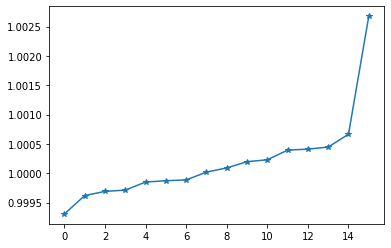

In [12]:
eigen_values =sorted(evalue.mean(axis=0))
plt.plot(eigen_values,marker="*")

In [13]:
data = load_wine()
X = data.data
y = data.target
k = len(np.unique(y))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
S = cosine_similarity(X,X)
D  = np.diag(1.0/S.sum(axis=1))
X_train = torch.tensor(D.dot(S)).float().numpy()
kmeans.fit(X_train)

KMeans(n_clusters=3)

In [14]:
nmi = normalized_mutual_info_score(kmeans.labels_,y,average_method="arithmetic")
print(nmi)    

0.6351524906645799


In [16]:
from sklearn.cluster import SpectralClustering


### Comparing eigengap between spectral clustering and graphEncoder

Making three different datasets using gausian distribution

In [9]:
std = [1,0.5,0.3]
clusters = []
data = []
for st in std:
    cluster1 = np.random.normal(2,st,100)
    cluster2 = np.random.normal(4,st,100)
    cluster3 = np.random.normal(6,st,100)
    clusters.append([cluster1,cluster2,cluster3])
    data.append(np.concatenate((cluster1,cluster2,cluster3)))
    

In [43]:
from sklearn.cluster import SpectralClustering
from scipy.linalg import  eigh 
cluster = SpectralClustering(n_clusters=3,assign_labels='discretize')

cluster.fit_predict(data[0].reshape(-1,1))
cluster.get_params()

{'affinity': 'rbf',
 'assign_labels': 'discretize',
 'coef0': 1,
 'degree': 3,
 'eigen_solver': None,
 'eigen_tol': 0.0,
 'gamma': 1.0,
 'kernel_params': None,
 'n_clusters': 3,
 'n_components': None,
 'n_init': 10,
 'n_jobs': None,
 'n_neighbors': 10,
 'random_state': None}

In [1]:
data = np.concatenate((cluster1,cluster2,cluster3))

NameError: name 'np' is not defined

(array([ 3.,  5.,  8., 22., 23., 17., 15.,  6.,  0.,  1.]),
 array([3.2060767 , 3.81852636, 4.43097602, 5.04342568, 5.65587534,
        6.268325  , 6.88077465, 7.49322431, 8.10567397, 8.71812363,
        9.33057329]),
 <a list of 10 Patch objects>)

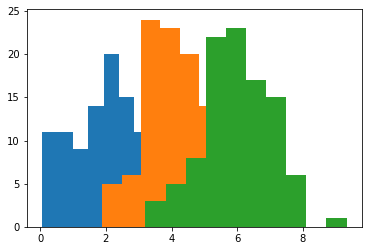

In [70]:
plt.hist(cluster1)
plt.hist(cluster2)
plt.hist(cluster3)

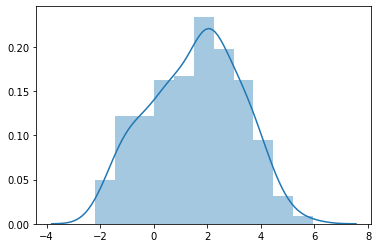

In [36]:
sns.distplot(data)

In [9]:
def normalised_laplacian(S,style="rw"):
    w = S.sum(axis=0)
    D = np.diag(1.0/w)
    
    if style=="rw":
        return D.dot(S)
    if style=="sym":
        D = np.diag(1.0/np.sqrt(W))
        return D.dot(S).dot(D)

def kmeans()
    
    
S,y,n_clusters= wine_data()


laplacian = normalised_laplacian(S)



In [10]:
laplacian 

array([[0.0061628 , 0.00597932, 0.00600893, ..., 0.00526824, 0.00535448,
        0.00515907],
       [0.00586888, 0.00604897, 0.00581192, ..., 0.00526945, 0.00533792,
        0.00509128],
       [0.00589654, 0.00581053, 0.00604753, ..., 0.0053212 , 0.00539064,
        0.00526155],
       ...,
       [0.00531632, 0.0054176 , 0.00547211, ..., 0.00621904, 0.00614325,
        0.0060436 ],
       [0.00533775, 0.00542137, 0.00547622, ..., 0.00606868, 0.00614355,
        0.00596763],
       [0.0052458 , 0.00527428, 0.00545197, ..., 0.00608962, 0.00608696,
        0.0062664 ]])